Group Members: Dhruv, Rohan, Sarthak, Uday

In [6]:
# !pip install yahoofinance
# !pip install hmmlearn
# !pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

from modules.directional_change import get_data, get_DC_data, get_DC_data_v2, get_TMV, get_T, get_R
from modules.hidden_markov_model import fit_hmm
from modules.cross_validation import Pipeline, CustomCrossValidation

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme()

In [49]:
"""Hyperparameters"""

TYPE = 'equity' # 'equity' or 'fx' or 'bond'

TICKER_MAPPER = {'equity':['^DJI','^GSPC'],
                'bond':['^TNX', '^IRX'],
                'fx':['RUB=X','GBP=X']}

TICKERS = TICKER_MAPPER[TYPE]
START_DATE = "2005-01-01"
TRAIN_END = "2017-12-31"
VALID_START = "2018-01-01"
VALID_END = "2019-12-31"
TEST_START = "2020-01-01"

THETA = 0.025
NUM_REGIMES = 2

TRADING_DAY = {'equity':6.5, 'fx':12,'bond':9} # number of hours in a day we offset

In [50]:
pipeline = Pipeline(theta=0.025, type_mapper = {'equity':['^GSPC']}, strat = "control" )
pipeline.fit(plot=False, verbose=False)

[*********************100%***********************]  1 of 1 completed
46
46


In [51]:
pipeline.trading_metrics

{'drawdown': 0.1765764305190159,
 'profit': -0.08193893237365257,
 'sharpe': -0.10237801888457851}

In [52]:
pipeline = Pipeline(theta=0.025, type_mapper = {'equity':['^GSPC']} )
pipeline.fit(plot=False, verbose=False)
pipeline.trading_metrics

[*********************100%***********************]  1 of 1 completed
46
46


{'drawdown': 0.21301087772186017,
 'profit': -0.07459833552196327,
 'sharpe': -0.014698364409335125}

# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

## Plotting data

[*********************100%***********************]  2 of 2 completed


,^DJI,^GSPC
count,9061.000000,9061.000000
mean,0.000209,0.000219
std,0.012987,0.013515
min,-0.138348,-0.124082
25%,-0.005315,-0.005447
50%,0.000128,0.000115
75%,0.005850,0.006119
max,0.117979,0.126971


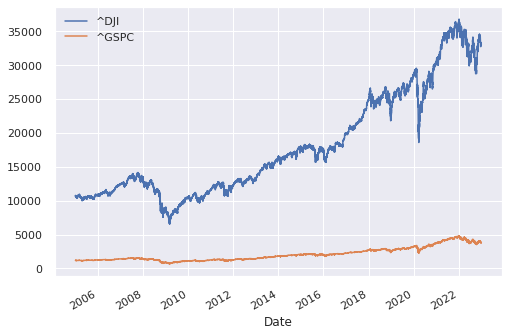

In [53]:
df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

DC = {}

for ticker in TICKERS:
    DC[ticker] = get_DC_data(df_ts[ticker], THETA)

tmv = {}
T = {}
R = {}
for ticker in TICKERS:
    tmv[ticker] = get_TMV(DC[ticker],THETA)
    T[ticker] = get_T(DC[ticker])
    R[ticker] = get_R(tmv[ticker],T[ticker],THETA)

df_ts.plot()
df_ret.describe()

## Visualizing DC indicators

In [54]:
df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

DC = {}
for ticker in TICKERS:
    DC[ticker] = get_DC_data(df_ts[ticker], THETA)

# example
sample_ts = df_ts[TEST_TICKER][:50]
last_date = sample_ts.index[-1]

dcc = []
dcc_idx = []
ext = []
ext_idx = []

for i in range(len(DC[TEST_TICKER])):
    dcc.append(DC[TEST_TICKER][i][1])
    dcc_idx.append(DC[TEST_TICKER][i][0])
    ext.append( DC[TEST_TICKER][i][3] )
    ext_idx.append( DC[TEST_TICKER][i][2] )
    
dcc = pd.Series( data=dcc, index = dcc_idx)
ext = pd.Series( data=ext, index = ext_idx)

sample_dcc = dcc.loc[:last_date].index
sample_ext = ext.loc[:last_date].index

fig,ax = plt.subplots()
sample_ts.plot(ax=ax, color ='black')
ymin, ymax = sample_ts.min(), sample_ts.max()
ax.vlines(sample_ext, ymin, ymax, 'r','dashed',label='EXT',alpha=0.6)
ax.vlines(sample_dcc, ymin, ymax, 'navy','dashed',label='DCC',alpha=0.6)
ax.set_title(f"DC indicators for {TEST_TICKER} with threshold {THETA}")
ax.set_ylabel("Price")
ax.legend()
plt.show()

[*********************100%***********************]  2 of 2 completed


KeyError: '^IXIC'

## New version of DC indicators where we allow opposite direction movements

[*********************100%***********************]  2 of 2 completed


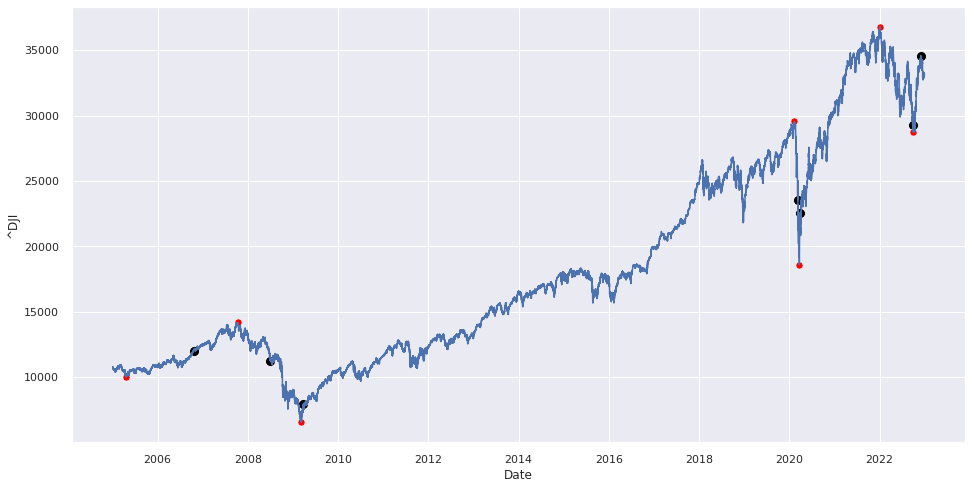

In [55]:
df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

features = get_DC_data_v2(df_ts[TICKERS[0]], 0.2)
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df_ts[TICKERS[0]])
sns.scatterplot(x = [i[0] for i in features], y = [i[1] for i in features], color='black', s=100)
sns.scatterplot(x = [i[2] for i in features], y = [i[3] for i in features], color='red', s=50)
None

# Pipeline With Cross-Validation

In [56]:
parameter_grid = {
    'theta': np.arange(0.01, stop=0.10, step=0.005),
    'DC_indicator': ['R'],
    'threshold': [0.25]
}

In [59]:
trading_day = {'equity':6.5, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv.fit(data = df_ts, metric='sharpe', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 0: Parameters: {'DC_indicator': 'R', 'theta': 0.01, 'threshold': 0.25}
Iteration: 0: Training complete.
Iteration: 0: Loss: {'drawdown': 0.14034430737217615, 'profit': 0.04009513394916553, 'sharpe': 0.21121458975509835}
Iteration: 1: Parameters: {'DC_indicator': 'R', 'theta': 0.015, 'threshold': 0.25}
Iteration: 1: Training complete.
Iteration: 1: Loss: {'drawdown': 0.14516350295701666, 'profit': 0.11600591952033956, 'sharpe': 0.3957019109006989}
Iteration: 2: Parameters: {'DC_indicator': 'R', 'theta': 0.019999999999999997, 'threshold': 0.25}
Iteration: 2: Training complete.
Iteration: 2: Loss: {'drawdown': 0.1401665355657412, 'profit': 0.08764020338146472, 'sharpe': 0.2917519267891548}
Iteration: 3: Parameters: {'DC_indicator': 'R', 'theta': 0.024999999999999998, 'threshold': 0.25}
Iteration: 3: Training complete.
Iteration: 3: Loss: {'drawdown': 0.2130108777218601, 'profit': -0.1272721221618942, 'sharpe':

In [60]:
cv.get_optimal_parameters()

{'DC_indicator': 'R', 'theta': 0.015, 'threshold': 0.25}

In [61]:
cv.get_optimal_loss()

{'drawdown': 0.14516350295701666,
 'profit': 0.11600591952033956,
 'sharpe': 0.3957019109006989}

Total duration of time: 397612800.0
Total duration spent in Regime 1: 143593200.0
Proportion of time spent in Regime 1: 0.3611382732145444
Flipping labels between regimes.


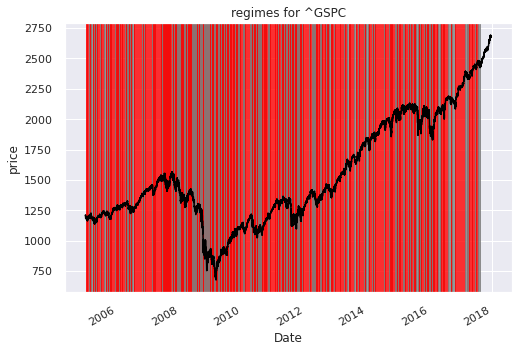

In [66]:
control = Pipeline(df_ts= df_ts, strat='control', **cv.get_optimal_parameters())
control.fit(plot=True, verbose = True)

In [69]:
control.regimes

2005-01-14 06:30:00    1
2005-01-19 06:30:00    0
2005-01-25 06:30:00    1
2005-02-17 06:30:00    0
2005-02-23 06:30:00    1
                      ..
2017-05-18 06:30:00    1
2017-06-19 00:00:00    0
2017-07-06 00:00:00    1
2017-07-27 06:30:00    0
2017-08-21 06:30:00    1
Length: 1047, dtype: int64

In [63]:
control.trading_metrics

{'drawdown': 0.22510553533913238,
 'profit': 0.2741093460016346,
 'sharpe': 1.0483315633308063}

In [95]:
cv.get_optimal_parameters()

{'DC_indicator': 'R', 'theta': 0.015, 'threshold': 0.25}

In [152]:
'''On test data'''
strat_test = Pipeline(df_ts= df_ts, DC_indicator = 'R', epsilon = 0.8, theta = 0.01, threshold = 1, to_test = True)
# strat_test = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters(), epsilon = 0.75, to_test = True)
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407745000.0
Total duration spent in Regime 1: 161935200.0
Proportion of time spent in Regime 1: 0.39714821763602254
Flipping labels between regimes.


{'drawdown': 0.24764473663226932,
 'profit': 1.6586864219122472,
 'sharpe': 1.4017946969975341}

In [153]:
# control_test = Pipeline(df_ts= df_ts, strat = 'control', **cv.get_optimal_parameters(), to_test = True)
# control_test.fit()
# control_test.trading_metrics_test

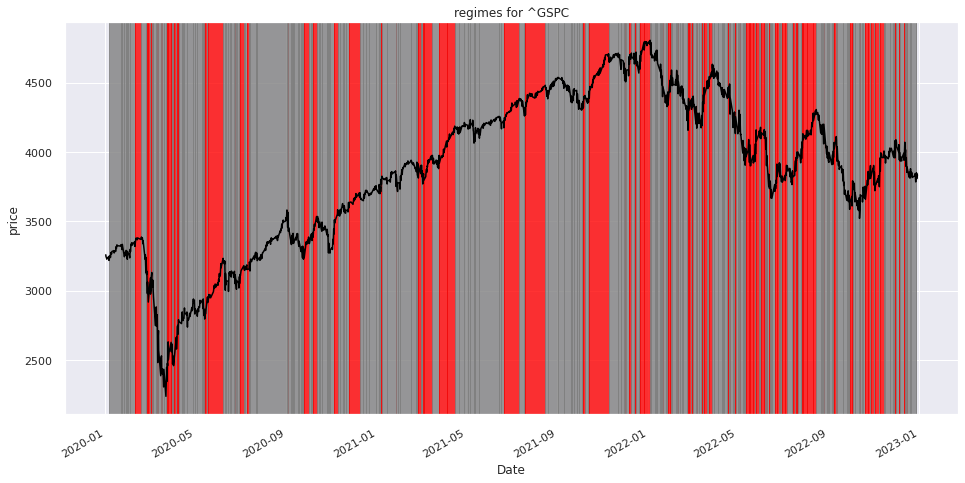

In [154]:
regimes = strat_test.regimes_test


fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=0.8, color=clr[regime])
ax.set_title(f"regimes for {ticker}")
ax.set_ylabel("price")
plt.show()

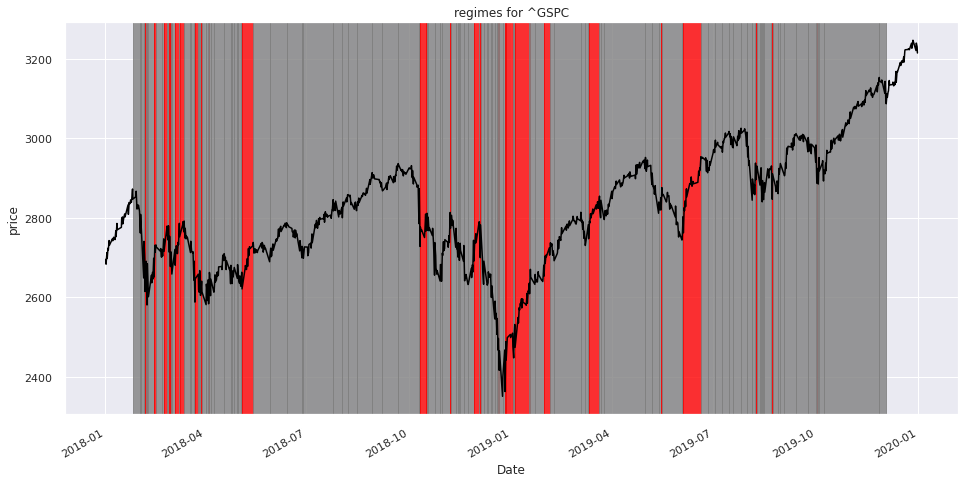

In [155]:
regimes = strat_test.regimes_valid


fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=0.8, color=clr[regime])
ax.set_title(f"regimes for {ticker}")
ax.set_ylabel("price")
plt.show()